In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [3]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        return np.sum(result)

In [4]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 90 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [5]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [6]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [7]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [8]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [9]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [10]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [11]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [12]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [13]:
%%time
add_lunar_date(df)

CPU times: user 2min 14s, sys: 486 ms, total: 2min 15s
Wall time: 2min 15s


In [14]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [15]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [16]:
s[s > 10].index.tolist()[0]

20170315

In [17]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [18]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [19]:
get_prev_date('20170101')

'2016123100'

In [20]:
get_today_from_07('20170101')

'2017010100'

In [21]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [22]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    day = get_prev_date(d)
    #day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031400 2017031500
2017121000 2017121100
2016112900 2016113000
2017033000 2017033100
2014102200 2014102300
2016101900 2016102000
2014051700 2014051800
2017021100 2017021200
2015071700 2015071800
2014070500 2014070600
2015062600 2015062700
2016082900 2016083000
2017102200 2017102300
2017101100 2017101200
2014122000 2014122100
2017091500 2017091600
2016012100 2016012200
2015040300 2015040400
2015011200 2015011300
2014092400 2014092500
2017060200 2017060300
2016122500 2016122600
2015121200 2015121300
2016030300 2016030400
2015111200 2015111300


600

In [23]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 97 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 no

### add time sequence

In [24]:
inseq = 2
sequnce_features = df.columns.drop(['hour','climate', 'weather_deterioration', 'swell','day_hour', 'year', 'lunar_year',
       'month_sin', 'month_cos', 'lunar_month_sin', 'lunar_month_cos',
       'day_sin', 'day_cos', 'lunar_ay_sin', 'lunar_day_cos', 'weekday_sin',
       'weekday_cos', 'swell(t+1)']).tolist()

In [25]:
temp_cols = []
temp_names = []
for i in range(1,inseq):
    temp_cols.append(df[sequnce_features].shift(i))
    temp_names += [feature_name+'(t-{})'.format(i) for feature_name in sequnce_features]

In [26]:
seq_df = pd.concat(temp_cols,axis=1)
seq_df.columns = temp_names

df = pd.concat([df,seq_df],axis=1).iloc[inseq+1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34989 entries, 3 to 34991
Columns: 176 entries, hour to 22189_파향(deg)(t-1)
dtypes: float64(172), int64(3), object(1)
memory usage: 47.2+ MB


In [27]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [28]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [29]:
df.columns

Index(['climate', 'weather_deterioration', 'swell', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_수온(°C)', '22490_최대파고(m)',
       ...
       '22189_현지기압(hPa)(t-1)', '22189_습도(%)(t-1)', '22189_기온(°C)(t-1)',
       '22189_수온(°C)(t-1)', '22189_최대파고(m)(t-1)', '22189_유의파고(m)(t-1)',
       '22189_평균파고(m)(t-1)', '22189_파주기(sec)(t-1)', '22189_파향(deg)(t-1)',
       'index'],
      dtype='object', length=176)

### 테스트 데이터 하나당 feature selection을 수행

In [30]:
test_date_hour = sorted(test_date_hour)
test_date_hour

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806',
 '2014070507',
 '2014070508',
 '2014070509',
 '2014070510',
 '2014070511',
 '2014070512',
 '2014070513',
 '2014070514',
 '2014070515',
 '2014070516',
 '2014070517',
 '2014070518',
 '2014070519',
 '2014070520',
 '2014070521',
 '2014070522',
 '2014070523',
 '2014070600',
 '2014070601',
 '2014070602',
 '2014070603',
 '2014070604',
 '2014070605',
 '2014070606',
 '2014092407',
 '2014092408',
 '2014092409',
 '2014092410',
 '2014092411',
 '2014092412',
 '2014092413',
 '2014092414',
 '2014092415',
 '2014092416',
 '2014092417',
 '2014092418',
 '2014092419',
 '2014092420',
 '2014092421',
 '2014092422',
 '2014092423',
 '2014092500',
 '20140925

### col 중 20% 이상의 미싱벨류가 있는 경우 삭제

In [31]:
drop_features = ['swell(t+1)','swell','weather_deterioration','index','climate']

In [32]:
%%time

model_scores = []
imp_features = []
preds = [] 

for i,test_date in enumerate(test_date_hour):
    st = time.time()
    all_df = df.loc[:test_date]
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    train_X = possible_df.iloc[:-1].drop(drop_features,axis=1)
    train_y = possible_df.iloc[:-1]['swell(t+1)']
    
    test_X = pd.DataFrame(possible_df.iloc[-1]).T\
                .drop(drop_features,axis=1)
    test_y = pd.DataFrame(possible_df.iloc[-1]).T\
                ['swell(t+1)']
    
    model = RandomForestClassifier(n_estimators=150,n_jobs=4)
    model.fit(train_X,train_y)
    
    pred = model.predict(test_X)
    preds.append(pred[0])
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_features.append(train_X.columns[indices].tolist())
    print(i,'training {} ~ {} size: {}, test {}, {} sec done - pred:{} real:{}, {}'\
              .format(train_X.index[0],train_X.index[-1], len(train_X),test_X.index[0],round(time.time()-st,2),
                      pred[0],test_y[0],pred[0] == test_y[0]))

0 training 2014010410 ~ 2014051706 size: 3189, test 2014051707, 0.77 sec done - pred:0.0 real:0.0, True
1 training 2014010410 ~ 2014051707 size: 3190, test 2014051708, 0.74 sec done - pred:0.0 real:0.0, True
2 training 2014010410 ~ 2014051708 size: 3191, test 2014051709, 0.75 sec done - pred:0.0 real:0.0, True
3 training 2014010410 ~ 2014051709 size: 3192, test 2014051710, 0.75 sec done - pred:0.0 real:0.0, True
4 training 2014010410 ~ 2014051710 size: 3193, test 2014051711, 0.75 sec done - pred:0.0 real:0.0, True
5 training 2014010410 ~ 2014051711 size: 3194, test 2014051712, 0.75 sec done - pred:0.0 real:2.0, False
6 training 2014010410 ~ 2014051712 size: 3195, test 2014051713, 0.76 sec done - pred:0.0 real:2.0, False
7 training 2014010410 ~ 2014051713 size: 3196, test 2014051714, 0.76 sec done - pred:2.0 real:2.0, True
8 training 2014010410 ~ 2014051714 size: 3197, test 2014051715, 0.75 sec done - pred:2.0 real:2.0, True
9 training 2014010410 ~ 2014051715 size: 3198, test 2014051716

79 training 2014010410 ~ 2014102213 size: 6988, test 2014102214, 1.28 sec done - pred:1.0 real:1.0, True
80 training 2014010410 ~ 2014102214 size: 6989, test 2014102215, 1.29 sec done - pred:1.0 real:1.0, True
81 training 2014010410 ~ 2014102215 size: 6990, test 2014102216, 1.29 sec done - pred:1.0 real:1.0, True
82 training 2014010410 ~ 2014102216 size: 6991, test 2014102217, 1.28 sec done - pred:1.0 real:1.0, True
83 training 2014010410 ~ 2014102217 size: 6992, test 2014102218, 1.3 sec done - pred:1.0 real:2.0, False
84 training 2014010410 ~ 2014102218 size: 6993, test 2014102219, 1.29 sec done - pred:2.0 real:2.0, True
85 training 2014010410 ~ 2014102219 size: 6994, test 2014102220, 1.29 sec done - pred:2.0 real:2.0, True
86 training 2014010410 ~ 2014102220 size: 6995, test 2014102221, 1.29 sec done - pred:2.0 real:2.0, True
87 training 2014010410 ~ 2014102221 size: 6996, test 2014102222, 1.29 sec done - pred:2.0 real:2.0, True
88 training 2014010410 ~ 2014102222 size: 6997, test 20

157 training 2014010410 ~ 2015040319 size: 10906, test 2015040320, 1.5 sec done - pred:0.0 real:0.0, True
158 training 2014010410 ~ 2015040320 size: 10907, test 2015040321, 1.49 sec done - pred:0.0 real:0.0, True
159 training 2014010410 ~ 2015040321 size: 10908, test 2015040322, 1.5 sec done - pred:0.0 real:0.0, True
160 training 2014010410 ~ 2015040322 size: 10909, test 2015040323, 1.61 sec done - pred:0.0 real:0.0, True
161 training 2014010410 ~ 2015040323 size: 10910, test 2015040400, 1.71 sec done - pred:0.0 real:0.0, True
162 training 2014010410 ~ 2015040400 size: 10911, test 2015040401, 1.6 sec done - pred:0.0 real:0.0, True
163 training 2014010410 ~ 2015040401 size: 10912, test 2015040402, 1.81 sec done - pred:0.0 real:0.0, True
164 training 2014010410 ~ 2015040402 size: 10913, test 2015040403, 1.59 sec done - pred:0.0 real:0.0, True
165 training 2014010410 ~ 2015040403 size: 10914, test 2015040404, 1.51 sec done - pred:0.0 real:0.0, True
166 training 2014010410 ~ 2015040404 siz

234 training 2014010410 ~ 2015111300 size: 16263, test 2015111301, 2.33 sec done - pred:2.0 real:2.0, True
235 training 2014010410 ~ 2015111301 size: 16264, test 2015111302, 2.21 sec done - pred:2.0 real:2.0, True
236 training 2014010410 ~ 2015111302 size: 16265, test 2015111303, 2.21 sec done - pred:2.0 real:2.0, True
237 training 2014010410 ~ 2015111303 size: 16266, test 2015111304, 2.21 sec done - pred:2.0 real:2.0, True
238 training 2014010410 ~ 2015111304 size: 16267, test 2015111305, 2.34 sec done - pred:2.0 real:2.0, True
239 training 2014010410 ~ 2015111305 size: 16268, test 2015111306, 2.23 sec done - pred:2.0 real:2.0, True
240 training 2014010410 ~ 2015121206 size: 16965, test 2015121207, 2.33 sec done - pred:2.0 real:2.0, True
241 training 2014010410 ~ 2015121207 size: 16966, test 2015121208, 2.31 sec done - pred:2.0 real:2.0, True
242 training 2014010410 ~ 2015121208 size: 16967, test 2015121209, 2.33 sec done - pred:2.0 real:2.0, True
243 training 2014010410 ~ 2015121209 

311 training 2014010410 ~ 2016030405 size: 18956, test 2016030406, 2.63 sec done - pred:0.0 real:0.0, True
312 training 2014010410 ~ 2016082906 size: 23229, test 2016082907, 3.22 sec done - pred:1.0 real:2.0, False
313 training 2014010410 ~ 2016082907 size: 23230, test 2016082908, 3.15 sec done - pred:2.0 real:2.0, True
314 training 2014010410 ~ 2016082908 size: 23231, test 2016082909, 3.2 sec done - pred:2.0 real:2.0, True
315 training 2014010410 ~ 2016082909 size: 23232, test 2016082910, 3.21 sec done - pred:2.0 real:2.0, True
316 training 2014010410 ~ 2016082910 size: 23233, test 2016082911, 3.11 sec done - pred:2.0 real:2.0, True
317 training 2014010410 ~ 2016082911 size: 23234, test 2016082912, 3.23 sec done - pred:2.0 real:2.0, True
318 training 2014010410 ~ 2016082912 size: 23235, test 2016082913, 3.31 sec done - pred:2.0 real:2.0, True
319 training 2014010410 ~ 2016082913 size: 23236, test 2016082914, 3.21 sec done - pred:2.0 real:2.0, True
320 training 2014010410 ~ 2016082914 

388 training 2014010410 ~ 2016122510 size: 26065, test 2016122511, 3.66 sec done - pred:2.0 real:2.0, True
389 training 2014010410 ~ 2016122511 size: 26066, test 2016122512, 3.68 sec done - pred:2.0 real:2.0, True
390 training 2014010410 ~ 2016122512 size: 26067, test 2016122513, 3.57 sec done - pred:2.0 real:2.0, True
391 training 2014010410 ~ 2016122513 size: 26068, test 2016122514, 3.63 sec done - pred:2.0 real:2.0, True
392 training 2014010410 ~ 2016122514 size: 26069, test 2016122515, 3.68 sec done - pred:2.0 real:2.0, True
393 training 2014010410 ~ 2016122515 size: 26070, test 2016122516, 3.64 sec done - pred:2.0 real:2.0, True
394 training 2014010410 ~ 2016122516 size: 26071, test 2016122517, 3.66 sec done - pred:2.0 real:2.0, True
395 training 2014010410 ~ 2016122517 size: 26072, test 2016122518, 3.58 sec done - pred:2.0 real:0.0, False
396 training 2014010410 ~ 2016122518 size: 26073, test 2016122519, 3.74 sec done - pred:2.0 real:0.0, False
397 training 2014010410 ~ 201612251

465 training 2014010410 ~ 2017033015 size: 28350, test 2017033016, 4.39 sec done - pred:0.0 real:0.0, True
466 training 2014010410 ~ 2017033016 size: 28351, test 2017033017, 4.0 sec done - pred:0.0 real:0.0, True
467 training 2014010410 ~ 2017033017 size: 28352, test 2017033018, 3.99 sec done - pred:0.0 real:0.0, True
468 training 2014010410 ~ 2017033018 size: 28353, test 2017033019, 3.91 sec done - pred:0.0 real:0.0, True
469 training 2014010410 ~ 2017033019 size: 28354, test 2017033020, 4.12 sec done - pred:0.0 real:0.0, True
470 training 2014010410 ~ 2017033020 size: 28355, test 2017033021, 3.91 sec done - pred:0.0 real:0.0, True
471 training 2014010410 ~ 2017033021 size: 28356, test 2017033022, 4.1 sec done - pred:0.0 real:0.0, True
472 training 2014010410 ~ 2017033022 size: 28357, test 2017033023, 4.2 sec done - pred:0.0 real:0.0, True
473 training 2014010410 ~ 2017033023 size: 28358, test 2017033100, 3.89 sec done - pred:0.0 real:0.0, True
474 training 2014010410 ~ 2017033100 siz

542 training 2014010410 ~ 2017101120 size: 33035, test 2017101121, 5.12 sec done - pred:0.0 real:0.0, True
543 training 2014010410 ~ 2017101121 size: 33036, test 2017101122, 5.79 sec done - pred:0.0 real:0.0, True
544 training 2014010410 ~ 2017101122 size: 33037, test 2017101123, 5.46 sec done - pred:0.0 real:0.0, True
545 training 2014010410 ~ 2017101123 size: 33038, test 2017101200, 4.7 sec done - pred:0.0 real:0.0, True
546 training 2014010410 ~ 2017101200 size: 33039, test 2017101201, 5.4 sec done - pred:0.0 real:0.0, True
547 training 2014010410 ~ 2017101201 size: 33040, test 2017101202, 5.64 sec done - pred:0.0 real:0.0, True
548 training 2014010410 ~ 2017101202 size: 33041, test 2017101203, 6.02 sec done - pred:0.0 real:0.0, True
549 training 2014010410 ~ 2017101203 size: 33042, test 2017101204, 5.42 sec done - pred:0.0 real:0.0, True
550 training 2014010410 ~ 2017101204 size: 33043, test 2017101205, 5.32 sec done - pred:0.0 real:0.0, True
551 training 2014010410 ~ 2017101205 si

In [33]:
test = df.loc[test_date_hour][['swell(t+1)']].fillna(method='ffill')
test['pred'] = preds
test

,swell(t+1),pred
hour,,
2014051707,0.0,0.0
2014051708,0.0,0.0
2014051709,0.0,0.0
2014051710,0.0,0.0
2014051711,0.0,0.0
2014051712,2.0,0.0
2014051713,2.0,0.0
2014051714,2.0,2.0
2014051715,2.0,2.0


In [34]:
f1_score(test['pred'],test['swell(t+1)'],average='weighted')

0.92682617525510935

In [35]:
accuracy_score(test['pred'],test['swell(t+1)'])

0.92666666666666664

In [36]:
test['pred_swell'] = test['pred'].apply(lambda x: output_change(x))
test['real_swell'] = test['swell(t+1)'].apply(lambda x: output_change(x))
test

,swell(t+1),pred,pred_swell,real_swell
hour,,,,
2014051707,0.0,0.0,0,0
2014051708,0.0,0.0,0,0
2014051709,0.0,0.0,0,0
2014051710,0.0,0.0,0,0
2014051711,0.0,0.0,0,0
2014051712,2.0,0.0,0,1
2014051713,2.0,0.0,0,1
2014051714,2.0,2.0,1,1
2014051715,2.0,2.0,1,1


In [37]:
test['pred_swell'].value_counts()

0    408
1    192
Name: pred_swell, dtype: int64

In [38]:
f1_score(test['pred_swell'],test['real_swell'],average='weighted')

0.95542451634704739

In [39]:
class2 = test[test['real_swell']==1]
accuracy_score(class2['real_swell'],class2['pred_swell'])

0.89855072463768115

In [40]:
real = df.loc[test_date_hour]['swell(t+1)'].fillna(method='ffill')
real

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    2.0
2014051713    2.0
2014051714    2.0
2014051715    2.0
2014051716    2.0
2014051717    2.0
2014051718    2.0
2014051719    2.0
2014051720    2.0
2014051721    2.0
2014051722    2.0
2014051723    2.0
2014051800    2.0
2014051801    2.0
2014051802    2.0
2014051803    2.0
2014051804    2.0
2014051805    2.0
2014051806    2.0
2014070507    0.0
2014070508    0.0
2014070509    0.0
2014070510    0.0
2014070511    0.0
2014070512    0.0
             ... 
2017102301    1.0
2017102302    1.0
2017102303    1.0
2017102304    1.0
2017102305    1.0
2017102306    1.0
2017121007    0.0
2017121008    0.0
2017121009    0.0
2017121010    0.0
2017121011    0.0
2017121012    0.0
2017121013    0.0
2017121014    0.0
2017121015    0.0
2017121016    0.0
2017121017    0.0
2017121018    0.0
2017121019    0.0
2017121020    0.0
2017121021    0.0
2017121022    0.0
2017121023    0.0
2017121100    0.0
20171

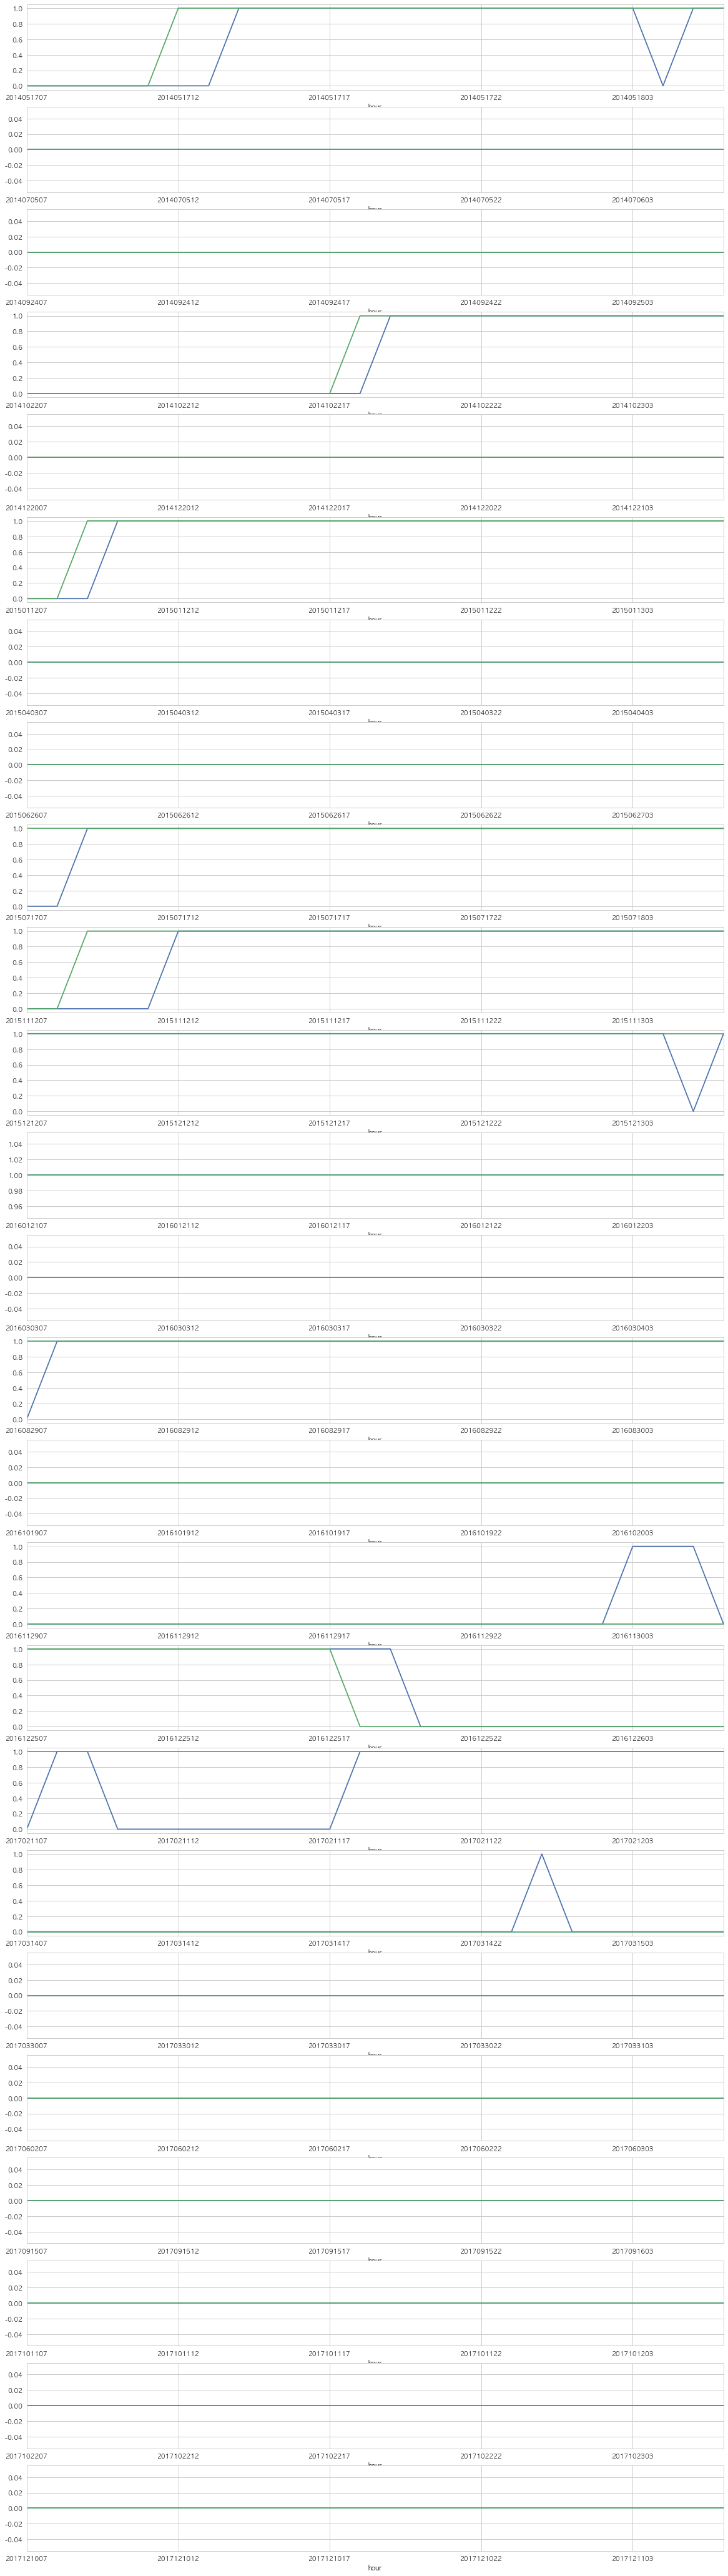

In [41]:
index = 0
for i in range(25):
    index = i*24
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()
    real.iloc[index:index+24].apply(lambda x:output_change(x)).plot()

In [42]:
index=0
test.iloc[index:index+24].T

hour,2014051707,2014051708,2014051709,2014051710,2014051711,2014051712,2014051713,2014051714,2014051715,2014051716,...,2014051721,2014051722,2014051723,2014051800,2014051801,2014051802,2014051803,2014051804,2014051805,2014051806
swell(t+1),0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
pred,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0
pred_swell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
real_swell,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [43]:
eval_metric = evaluation(df['swell(t+1)'].apply(output_change))

In [44]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['pred_swell'][st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
2    15
1     5
0     4
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
2    11
1    11
0     2
dtype: int64
96
1    24
dtype: int64
120
2    20
1     2
0     2
dtype: int64
144
1    24
dtype: int64
168
1    24
dtype: int64
192
2    21
0     3
dtype: int64
216
 2    18
 0     3
 1     2
-2     1
dtype: int64
240
2    22
0     2
dtype: int64
264
2    23
0     1
dtype: int64
288
1    24
dtype: int64
312
2    22
0     2
dtype: int64
336
1    24
dtype: int64
360
 1    21
-1     3
dtype: int64
384
2    11
1    11
0     2
dtype: int64
408
 2    14
 0     6
-2     4
dtype: int64
432
 1    23
-1     1
dtype: int64
456
1    24
dtype: int64
480
1    24
dtype: int64
504
1    24
dtype: int64
528
1    24
dtype: int64
552
1    24
dtype: int64
576
1    24
dtype: int64
[35, 24, 24, 33, 24, 42, 24, 24, 42, 36, 44, 46, 24, 44, 24, 18, 33, 20, 22, 24, 24, 24, 24, 24, 24]


In [45]:
np.sum(scores)

727

In [46]:
imp_features

[['22106_습도(%)',
  '22106_습도(%)(t-1)',
  '22453_평균파고(m)',
  '22453_평균파고(m)(t-1)',
  '22453_최대파고(m)',
  '22453_유의파고(m)',
  '22453_최대파고(m)(t-1)',
  '22105_풍향1(deg)',
  '22106_유의파고(m)',
  '21229_풍향1(deg)(t-1)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '22106_습도(%)(t-1)',
  '22453_유의파고(m)(t-1)',
  '22453_최대파고(m)',
  '22453_평균파고(m)(t-1)',
  '22453_최대파고(m)(t-1)',
  '22106_풍향1(deg)',
  '22453_유의파고(m)',
  '22106_최대파고(m)(t-1)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '22106_습도(%)(t-1)',
  '22453_평균파고(m)(t-1)',
  '22453_최대파고(m)(t-1)',
  '22453_최대파고(m)',
  '22453_유의파고(m)',
  '22453_유의파고(m)(t-1)',
  '21229_풍향1(deg)(t-1)',
  '22106_유의파고(m)(t-1)'],
 ['22453_평균파고(m)',
  '22453_최대파고(m)(t-1)',
  '22106_습도(%)(t-1)',
  '22106_습도(%)',
  '22453_평균파고(m)(t-1)',
  '22453_유의파고(m)',
  '22453_최대파고(m)',
  '22453_유의파고(m)(t-1)',
  '22106_유의파고(m)(t-1)',
  '22106_풍향1(deg)(t-1)'],
 ['22106_습도(%)',
  '22453_평균파고(m)',
  '22106_습도(%)(t-1)',
  '22453_유의파고(m)',
  '22453_유의파고(m)(t-1)',
  '22453_최대파고(m)(t-1)',
  '22453_최대파고(m)'

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]

#### seqeunce features
t = 2 ~ 6